In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from vis_settings import flux_types as colors

(PosixPath('cdr_20yr_cumulative_panels.png'),
 PosixPath('cdr_20yr_cumulative_panels.pdf'),
 [])

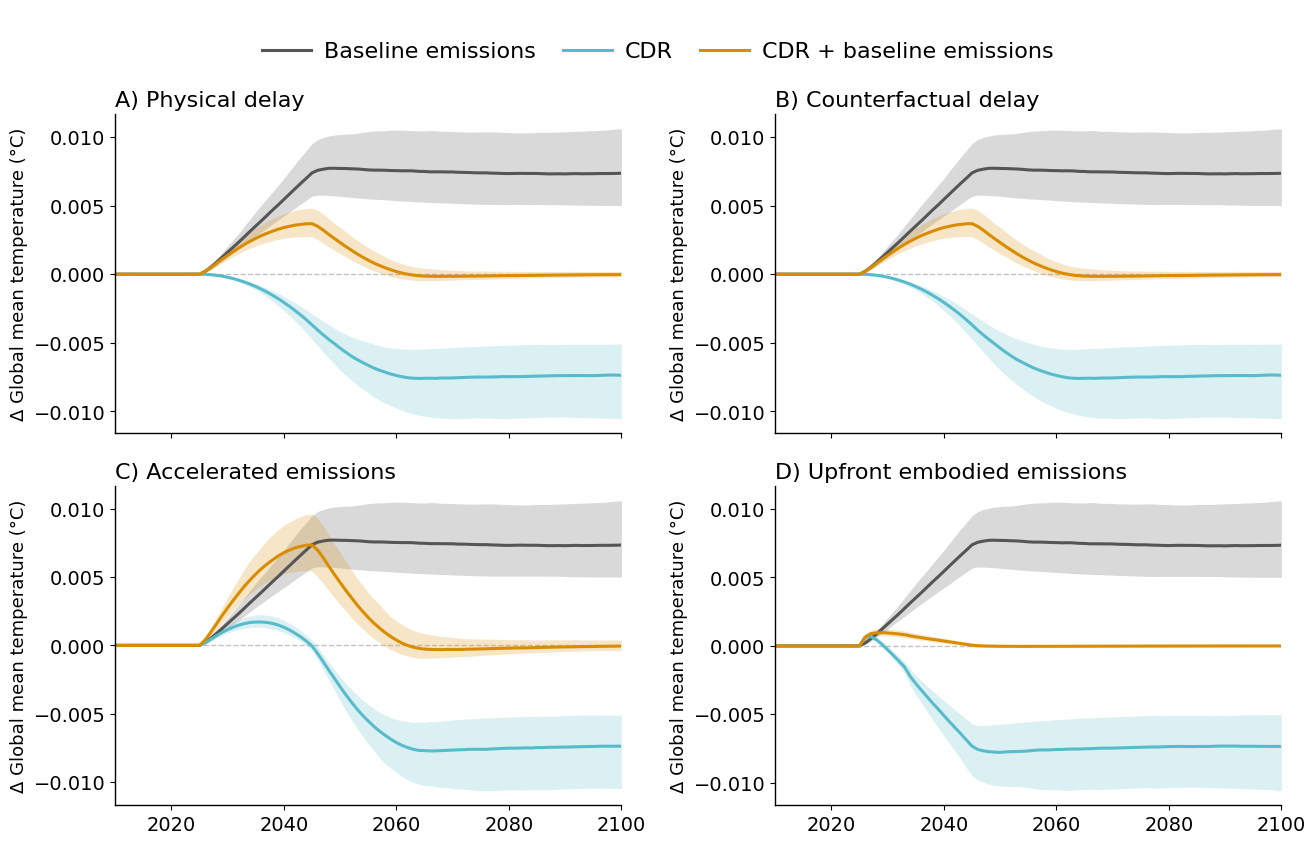

In [2]:
# Fix: Only create a shared legend if we actually have plotted lines.
# Re-run the panel plotting so it renders even if inputs are missing.

def graph_CDR_panels(panels, panel_titles, savename_base, 
                     year_min=2000, year_max=2100):
    plt.style.use('default')
    mpl.rcParams.update({
        'font.family'    : 'DejaVu Sans',
        'axes.grid'      : False,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.linewidth' : 1.0,
        'legend.frameon' : False,
        "font.size": 16,        # base font
        "axes.titlesize": 18,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "lines.linewidth": 3,
    })
    

    fig, axs = plt.subplots(2, 2, figsize=(14, 9), sharex=True, sharey=False)
    axs = axs.ravel()

    shared_handles, shared_labels = [], []
    all_missing = []

    for ax, scenarios, title in zip(axs, panels, panel_titles):
        ax.set_title(title, loc="left", fontsize=16)
        missing_files = []

        for case in scenarios:
            fpath = Path(case["file"])
            if not fpath.exists():
                missing_files.append(str(fpath))
                continue

            df = pd.read_csv(fpath)
            df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
            if 'Year' not in df.columns:
                if df.columns[0].lower().startswith('year'):
                    df.rename(columns={df.columns[0]: 'Year'}, inplace=True)
                elif df.columns[0].lower().startswith('timebounds'):
                    df.rename(columns={df.columns[0]: 'Year'}, inplace=True)
            df = df[(df['Year'] >= year_min) & (df['Year'] <= year_max)]
            ax.fill_between(df['Year'], df['diffs_05'], df['diffs_95'],
                            color=case["color"], alpha=0.22, linewidth=0)
            line, = ax.plot(df['Year'], df['diffs_50'],
                            color=case["color"], lw=2.2, label=case["label"])

            shared_handles.append(line)
            shared_labels.append(case["label"])

        ax.set_xlim(year_min, year_max)
        ax.set_xlabel('', fontsize=13)
        ax.set_ylabel('Δ Global mean temperature (°C)', fontsize=13)
        ax.axhline(0, color='0.6', lw=1.0, ls='--', alpha=0.6, zorder=0)

        if missing_files:
            all_missing.extend(missing_files)
            msg = "Missing files:\n" + "\n".join(Path(m).name for m in missing_files)
            ax.text(0.5, 0.5, msg, transform=ax.transAxes,
                    ha='center', va='center', fontsize=11,
                    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85))

    # Deduplicate legend entries
    seen = set()
    uniq_handles, uniq_labels = [], []
    for h, l in zip(shared_handles, shared_labels):
        if l not in seen:
            uniq_handles.append(h); uniq_labels.append(l); seen.add(l)

    if len(uniq_labels) > 0:
        fig.legend(uniq_handles, uniq_labels, loc='upper center',
                   ncol=len(uniq_labels), borderaxespad=1.5,
                   handlelength=2.2, handletextpad=0.6, columnspacing=1.2)
    
    fig.tight_layout(rect=[0.02, 0.02, 0.98, 0.90])

    out_png = Path(f"{savename_base}.png")
    out_pdf = Path(f"{savename_base}.pdf")
    fig.savefig(out_png, dpi=500, bbox_inches='tight')
    fig.savefig(out_pdf, bbox_inches='tight')
    return out_png, out_pdf, all_missing

# Use the same panel configuration as before
panels = [
    [
        {"file": "../data/modified/baseline_emissions_cumulative_low.csv", "label": "Baseline emissions", "color": "#555555"},
        {"file": "../data/modified/physical_delay_cdr_only_cumulative_low.csv", "label": "CDR", "color": colors['net-effect']},
        {"file": "../data/modified/physical_delay_cdr_emissions_cumulative_low.csv", "label": "CDR + baseline emissions", "color": colors['CDR+baseline']},
    ],
    [
        {"file": "../data/modified/baseline_emissions_cumulative_low.csv", "label": "Baseline emissions", "color": "#555555"},
        {"file": "../data/modified/counterfactual_delay_cdr_only_cumulative_low.csv", "label": "CDR", "color": colors['net-effect']},
        {"file": "../data/modified/counterfactual_delay_cdr_emissions_cumulative_low.csv", "label": "CDR + baseline emissions", "color": colors['CDR+baseline']},
    ],
    [
        {"file": "../data/modified/baseline_emissions_cumulative_low.csv", "label": "Baseline emissions", "color": "#555555"},
        {"file": "../data/modified/accelerated_emissions_cdr_only_cumulative_low.csv", "label": "CDR", "color": colors['net-effect']},
        {"file": "../data/modified/accelerated_emissions_cdr_emissions_cumulative_low.csv", "label": "CDR + baseline emissions", "color": colors['CDR+baseline']},
    ],
    [
        {"file": "../data/modified/baseline_emissions_cumulative_low.csv", "label": "Baseline emissions", "color": "#555555"},
        {"file": "../data/modified/upfront_emissions_cdr_only_cumulative_low.csv", "label": "CDR", "color": colors['net-effect']},
        {"file": "../data/modified/upfront_emissions_cdr_emissions_cumulative_low.csv", "label": "CDR + baseline emissions", "color": colors['CDR+baseline']},
    ],
]

panel_titles = [
    "A) Physical delay",
    "B) Counterfactual delay",
    "C) Accelerated emissions",
    "D) Upfront embodied emissions",
]

png_path, pdf_path, missing = graph_CDR_panels(
    panels, panel_titles, savename_base="cdr_20yr_cumulative_panels",
    year_min=2010, year_max=2100
)

png_path, pdf_path, [Path(m).name for m in missing]
